In [63]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.svm import SVC
import db_settings
import pyexasol
from pathlib import Path
import warnings
import csv
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import random
from mpl_toolkits.mplot3d import Axes3D
print(os.getcwd())

c:\Users\janja\Desktop\GitHub\lidar-vegetation-data


In [72]:
def get_class(id):
    family = dict_families[dict_gattung[id]['ID_FAMILIE']]
    order = dict_order[family['ID_ORDNUNG']]
    c = order['ID_KLASSE']
    return c
def get_order(id):
    family = dict_families[dict_gattung[id]['ID_FAMILIE']]
    o = family['ID_ORDNUNG']
    return o
def get_family(id):
    f = dict_families[dict_gattung[id]['ID_FAMILIE']]
    return f
    

    

In [3]:
db =db_settings.db(autocommit=False)


In [4]:
req_families = """SELECT * FROM lidar_proj.familien"""
req_order = """SELECT * FROM lidar_proj.ordnungen"""
req_class = """SELECT * FROM lidar_proj.klassen"""
req_gattung = """SELECT * FROM lidar_proj.gattungen"""

df_families = db.export_to_pandas(req_families)
df_order = db.export_to_pandas(req_order)
df_class = db.export_to_pandas(req_class)
df_gattung = db.export_to_pandas(req_gattung)

df_families.set_index("ID", drop=True, inplace=True)
df_order.set_index("ID", drop=True, inplace=True)
df_class.set_index("ID", drop=True, inplace=True)
df_gattung.set_index("ID", drop=True, inplace=True)

In [64]:
global dict_gattung
global dict_families
global dict_order
global dict_class

dict_gattung =df_gattung.to_dict(orient="index")

dict_families =df_families.to_dict(orient="index")
dict_order =df_order.to_dict(orient="index")
dict_class =df_class.to_dict(orient="index")
print(dict_gattung[1])


{'LAT_NAME': 'Abies', 'DT_NAME': ' \tTannen ', 'ID_FAMILIE': 1.0}


In [65]:
#luckup klasse
gattungs_id = 3
print(dict_gattung[gattungs_id])
family = dict_families[dict_gattung[gattungs_id]['ID_FAMILIE']]
print(family)
order = dict_order[family['ID_ORDNUNG']]
print(order)
c = dict_class[order['ID_KLASSE']]
print(c)


{'LAT_NAME': 'Aesculus', 'DT_NAME': ' \tRosskastanien  ', 'ID_FAMILIE': 2.0}
{'LAT_NAME': 'Sapindaceae', 'DT_NAME': ' Seifenbaumgewächse ', 'ID_ORDNUNG': 4}
{'LAT_NAME': 'Sapindales', 'DT_NAME': 'Seifenbaumartige ', 'ID_KLASSE': 1}
{'LAT_NAME': 'Magnoliopsida', 'DT_NAME': ' Bedecktsamer'}


In [95]:
csv_folder ='clusters/dbscan'
extension = '*.csv' 
features_list = []
for file in Path(csv_folder).glob(extension):
        df = pd.read_csv(file)
        features_list.append(df)
print(len(features_list), " files imported")
individuals = []
for df in features_list:     
        cluster_ids = np.unique(np.array(df['Cluster_ID']).astype(int))
        for id in cluster_ids:
                df_split =df[df['Cluster_ID'] == id]
                individuals.append(df_split)
features =[]
labels_unedited = []
max_points = 0
for individuum in individuals:
        id = np.unique(np.array(individuum['Cluster_ID']).astype(int))[0]
        gattung = np.unique(np.array(individuum['GATTUNGS_ID']).astype(int))[0]
        xyz = list(np.array([individuum['x'],individuum['y'],individuum['z']]).transpose())
        #wieviele punkte hat die größte Punktwolke
       
        feature = [individuum.describe()['x']['count']]
        labels_unedited.append(gattung)
        for xyz in ['x', 'y', 'z']:   
                feature += [individuum.describe()[xyz]['mean'], individuum.describe()[xyz]['std'], individuum.describe()[xyz]['min'],individuum.describe()[xyz]['max'], individuum.describe()[xyz]['25%'],individuum.describe()[xyz]['50%'], individuum.describe()[xyz]['75%']]
        features.append(feature)
        


10  files imported


In [100]:
#set labels to class-labels
labels = np.array(list(map(get_class, labels_unedited)))

#mappimg ginko as conidera
labels = np.array(list(map(lambda x: 2 if x==3 else x, labels)))

print(labels)
print(len(labels), " individuums in train/test-set")

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 1 1 1 1 1 1 2 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1]
275  individuums in train/test-set


In [101]:
labels = np.array(labels)
features = np.array(features)
print(len(labels))
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)
print(X_train.shape, len(y_train))
print("test-set:", list(zip(X_test, y_test)))

275
(184, 22) 184


In [102]:
#svm linear kernel
print(X_train.shape)
print(y_train.shape)
svc_linear = SVC(kernel='linear', probability=True, class_weight='balanced')  #, class_weight='balanced'
svc_linear.fit(X_train, y_train)
y_pred = svc_linear.predict(X_test)
print(list(zip(y_pred, y_test)))
print(accuracy_score(y_test, y_pred))

print(balanced_accuracy_score(y_test, y_pred, adjusted=True))


(184, 22)
(184,)
[(1, 1), (1, 1), (1, 1), (2, 1), (1, 1), (1, 2), (2, 1), (2, 1), (2, 1), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (2, 1), (1, 1), (1, 1), (2, 1), (2, 1), (1, 1), (1, 1), (2, 1), (1, 2), (1, 1), (2, 1), (2, 1), (1, 1), (1, 1), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (2, 1), (1, 1), (1, 1), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (2, 1), (1, 1), (1, 1), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (2, 1), (1, 1), (1, 1), (1, 2), (1, 1), (1, 1), (2, 1), (2, 1), (2, 2), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)]
0.7252747252747253
-0.002873563218390829


In [103]:
#Support vector machine with a radial basis function kernel

svc_rbf = SVC(kernel='rbf', probability=True, class_weight='balanced')
svc_rbf.fit(X_train, y_train)
y_pred = svc_rbf.predict(X_test)
print(list(zip(y_pred, y_test)))
print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred, adjusted=True))


[(2, 1), (2, 1), (1, 1), (2, 1), (2, 1), (2, 2), (2, 1), (2, 1), (2, 1), (2, 1), (1, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 2), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (1, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 2), (1, 1), (2, 1), (2, 1), (2, 1), (2, 2), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (2, 1), (1, 1)]
0.0989010989010989
0.05747126436781613


In [104]:
#Logistic regression
linear_lr = LogisticRegression(class_weight='balanced')
linear_lr.fit(X_train, y_train)
y_pred = linear_lr.predict(X_test)
print(list(zip(y_pred, y_test)))
print(accuracy_score(y_test, y_pred))
print(balanced_accuracy_score(y_test, y_pred, adjusted=True))


[(1, 1), (1, 1), (1, 1), (2, 1), (2, 1), (1, 2), (2, 1), (2, 1), (2, 1), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (2, 1), (1, 1), (1, 1), (2, 1), (2, 1), (1, 1), (1, 1), (2, 1), (1, 2), (1, 1), (2, 1), (2, 1), (1, 1), (2, 1), (2, 1), (2, 1), (1, 1), (1, 1), (2, 1), (2, 1), (1, 1), (1, 1), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (2, 1), (2, 1), (1, 1), (1, 1), (2, 1), (1, 1), (1, 1), (2, 1), (1, 1), (2, 1), (1, 1), (2, 1), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (2, 1), (1, 1), (1, 1), (1, 2), (1, 1), (2, 1), (2, 1), (2, 1), (2, 2), (2, 1), (1, 1), (1, 1), (1, 1), (2, 1), (2, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)]
0.6043956043956044
-0.1293103448275862


c:\Users\janja\anaconda3\envs\bahn\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1.

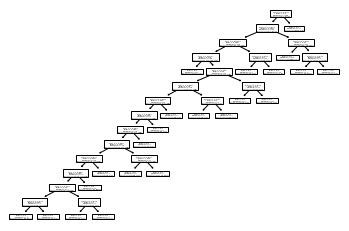

In [105]:
#decision tree 1:
clf = tree.DecisionTreeClassifier(class_weight='balanced')
clf = clf.fit(X_train, y_train)
print(clf.predict(X_test))
print(clf.predict_proba(X_test))
print(clf.score(X_test, y_test))

tree.plot_tree(clf)
print(balanced_accuracy_score(y_test, clf.predict(X_test), adjusted=True))


[1 1 1 1 1 1 2 2 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1
 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 2 1 1 1 1 1 2 1 1 1 1 1
 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1]
[[1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.08794788 0.91205212]
 [0.08794788 0.91205212]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.08794788 0.91205212]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.08794788 0

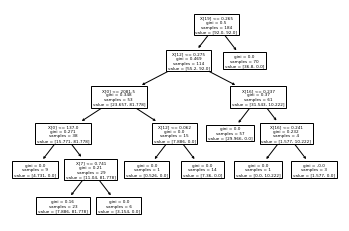

In [107]:
#decission tree 2:
decision_tree = DecisionTreeClassifier(random_state=0, max_depth=5, class_weight='balanced')
decision_tree = decision_tree.fit(X_train, y_train)
print(decision_tree.predict(X_test))
print(decision_tree.predict_proba(X_test))
print(decision_tree.score(X_test, y_test))

tree.plot_tree(decision_tree)
print(balanced_accuracy_score(y_test, decision_tree.predict(X_test), adjusted=True))


In [108]:
#random forest:
forest = RandomForestClassifier(n_estimators=100, class_weight='balanced')
forest.fit(X_train,y_train)
forest.predict(X_test)
forest.predict_proba(X_test)
print(forest.score(X_test, y_test))
print(balanced_accuracy_score(y_test, forest.predict(X_test), adjusted=True))




0.9560439560439561
0.0


In [110]:
#k-nearest neigbour
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

print(knn.score(X_test, y_test))
print(balanced_accuracy_score(y_test, knn.predict(X_test), adjusted=True))


0.9560439560439561
0.0
